In [35]:
import spacy
from spacy.matcher import Matcher
import pandas as pd
from tqdm import tqdm
import networkx as nx
import matplotlib.pyplot as plt

In [3]:
data = pd.read_csv(r'c:\Users\sravan\KG-Cybersec\dataset\lab3_dataset.csv')

In [4]:
nlp = spacy.load('en_core_web_lg')

In [5]:
data.head()

sentence
0                        Snort lab has prereq Linux
1          Snort lab has prereq Computer Networking
2                 Snort lab has prereq setup syslog
3          Snort lab uses syslog for remote logging
4  Snort lab has prereq deploy attacks using hping3

In [6]:
data.shape

(104, 1)

In [7]:
doc=nlp("Snort is used for signature based intrusion detection ")

In [8]:
for token in doc:
    print(token.text, "-->", token.dep_)

Snort --> nsubjpass
is --> auxpass
used --> ROOT
for --> prep
signature --> npadvmod
based --> amod
intrusion --> compound
detection --> pobj


In [9]:
def sub_obj_pair(sent):
    ent1 = ""
    ent2 = ""

    prev_dep = ""
    prev_token = ""

    modifier = ""
    prefix = ""

    for token in nlp(sent):
        if token.dep_ != 'punct':
            if token.dep_ == 'acl' or token.dep_ == "prep" or token.dep_ == "compound":
                prefix = token.text
                if prev_dep == ' compound':
                    prefix = prev_dep + " " + token.text
            if token.dep_.endswith("mod") == True:
                modifier = token.text
                if prev_token == 'compound':
                    modifier = prev_dep + " " + token.text
            
            if token.dep_.find("subj") == True:
                ent1 = modifier + " " + prefix + " " + token.text
                prefix = ""
                modifier = ""
                prev_dep = ""
                prev_token = ""
            
            if token.dep_.find("obj") == True:
                ent2 = ent2 + modifier + " " + prefix + " " + token.text
                prefix = ""
                modifier = ""
            
        prev_token = token.text
        prev_dep = token.dep_
    return[ent1.strip(), ent2.strip()]

In [10]:
entity = []
for i in tqdm(data['sentence']):
    entity.append(sub_obj_pair(i))

100%|██████████| 104/104 [00:00<00:00, 118.53it/s]


In [11]:
entity_df = pd.DataFrame(entity, columns=["subject", "object"])

In [12]:
entity_df.head()

subject                    object
0  Snort  lab                     Linux
1  Snort  lab       Computer Networking
2  Snort  lab              setup syslog
3  Snort  lab  syslogremote for logging
4      prereq                   attacks

In [13]:
sub_obj_pair("deep learning model will be given to students")

['deep learning model', 'students']

In [14]:
def get_relation(sent):
    doc=nlp(sent)
    matcher = Matcher(nlp.vocab)
    pattern = [ {'POS':'AUX','OP':"*"},
               {'DEP': 'ROOT'},
              {'DEP': 'prep', 'OP':"?"},
              {'DEP':'agent', 'OP':"?"},
              {'POS':'ADJ','OP':"?"}]
    
    matcher.add("matching_1", [pattern], on_match=None)
    
    matches= matcher(doc)
    k=len(matches)-2
    span= doc[matches[k][1]:matches[k][2]]
    
    return(span.text)

In [15]:
get_relation("Elastic application will offer cloud service")

'offer'

In [22]:
print(get_relation("all of the images are stored in google photos"))
print(sub_obj_pair("my of the images are stored in google photos"))

are stored in
['my', 'of images google photos']


In [23]:
relations = []
for i in tqdm(data['sentence']):
    relations.append(get_relation(i))

100%|██████████| 104/104 [00:01<00:00, 85.23it/s]


In [25]:
pd.Series(relations).value_counts()

has               10
is detecting       5
is tested          4
sets               3
shows              3
                  ..
installs           1
status             1
are located in     1
turns              1
is settting        1
Name: count, Length: 71, dtype: int64

In [26]:
source = [i[0] for i in entity]

target = [i[1] for i in entity]

kg_df = pd.DataFrame({'source': source, 'target': target, 'edge': relations})

In [27]:
kg_df.head()

source                    target        edge
0  Snort  lab                     Linux  has prereq
1  Snort  lab       Computer Networking  has prereq
2  Snort  lab              setup syslog         has
3  Snort  lab  syslogremote for logging        uses
4      prereq                   attacks      deploy

In [28]:
kg_df.to_csv('triple_csv')

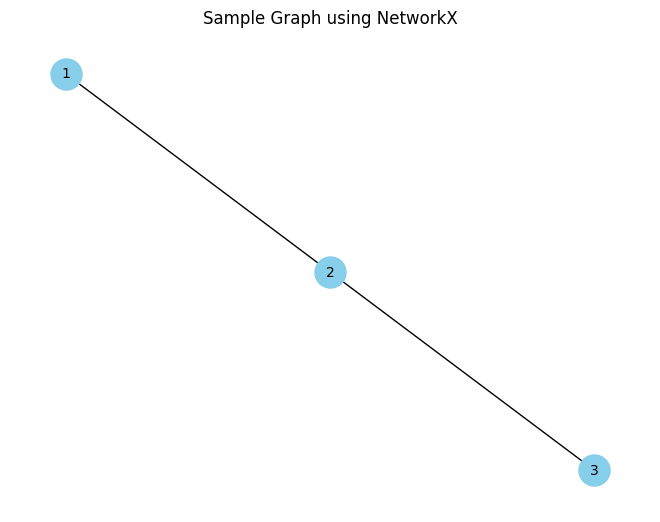

In [73]:
G = nx.Graph()

G.add_node(1)
G.add_node(2)
G.add_node(3)
G.add_edge(1, 2)
G.add_edge(2, 3)
G.nodes[1]['label'] = 'Node 1'
G.nodes[2]['label'] = 'Node 2'
G.nodes[3]['label'] = 'Node 3'
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, node_size=500, node_color='skyblue', font_size=10)
plt.title("Sample Graph using NetworkX")
plt.show()


In [43]:
# create a directed graph from a dataframe

G = nx.from_pandas_edgelist(kg_df, "source", "target", edge_attr=True, create_using=nx.MultiDiGraph())
#edge_labels= dict([((u,v), relations[d['weight']]) for u,v, d in G.edges(data=True)])

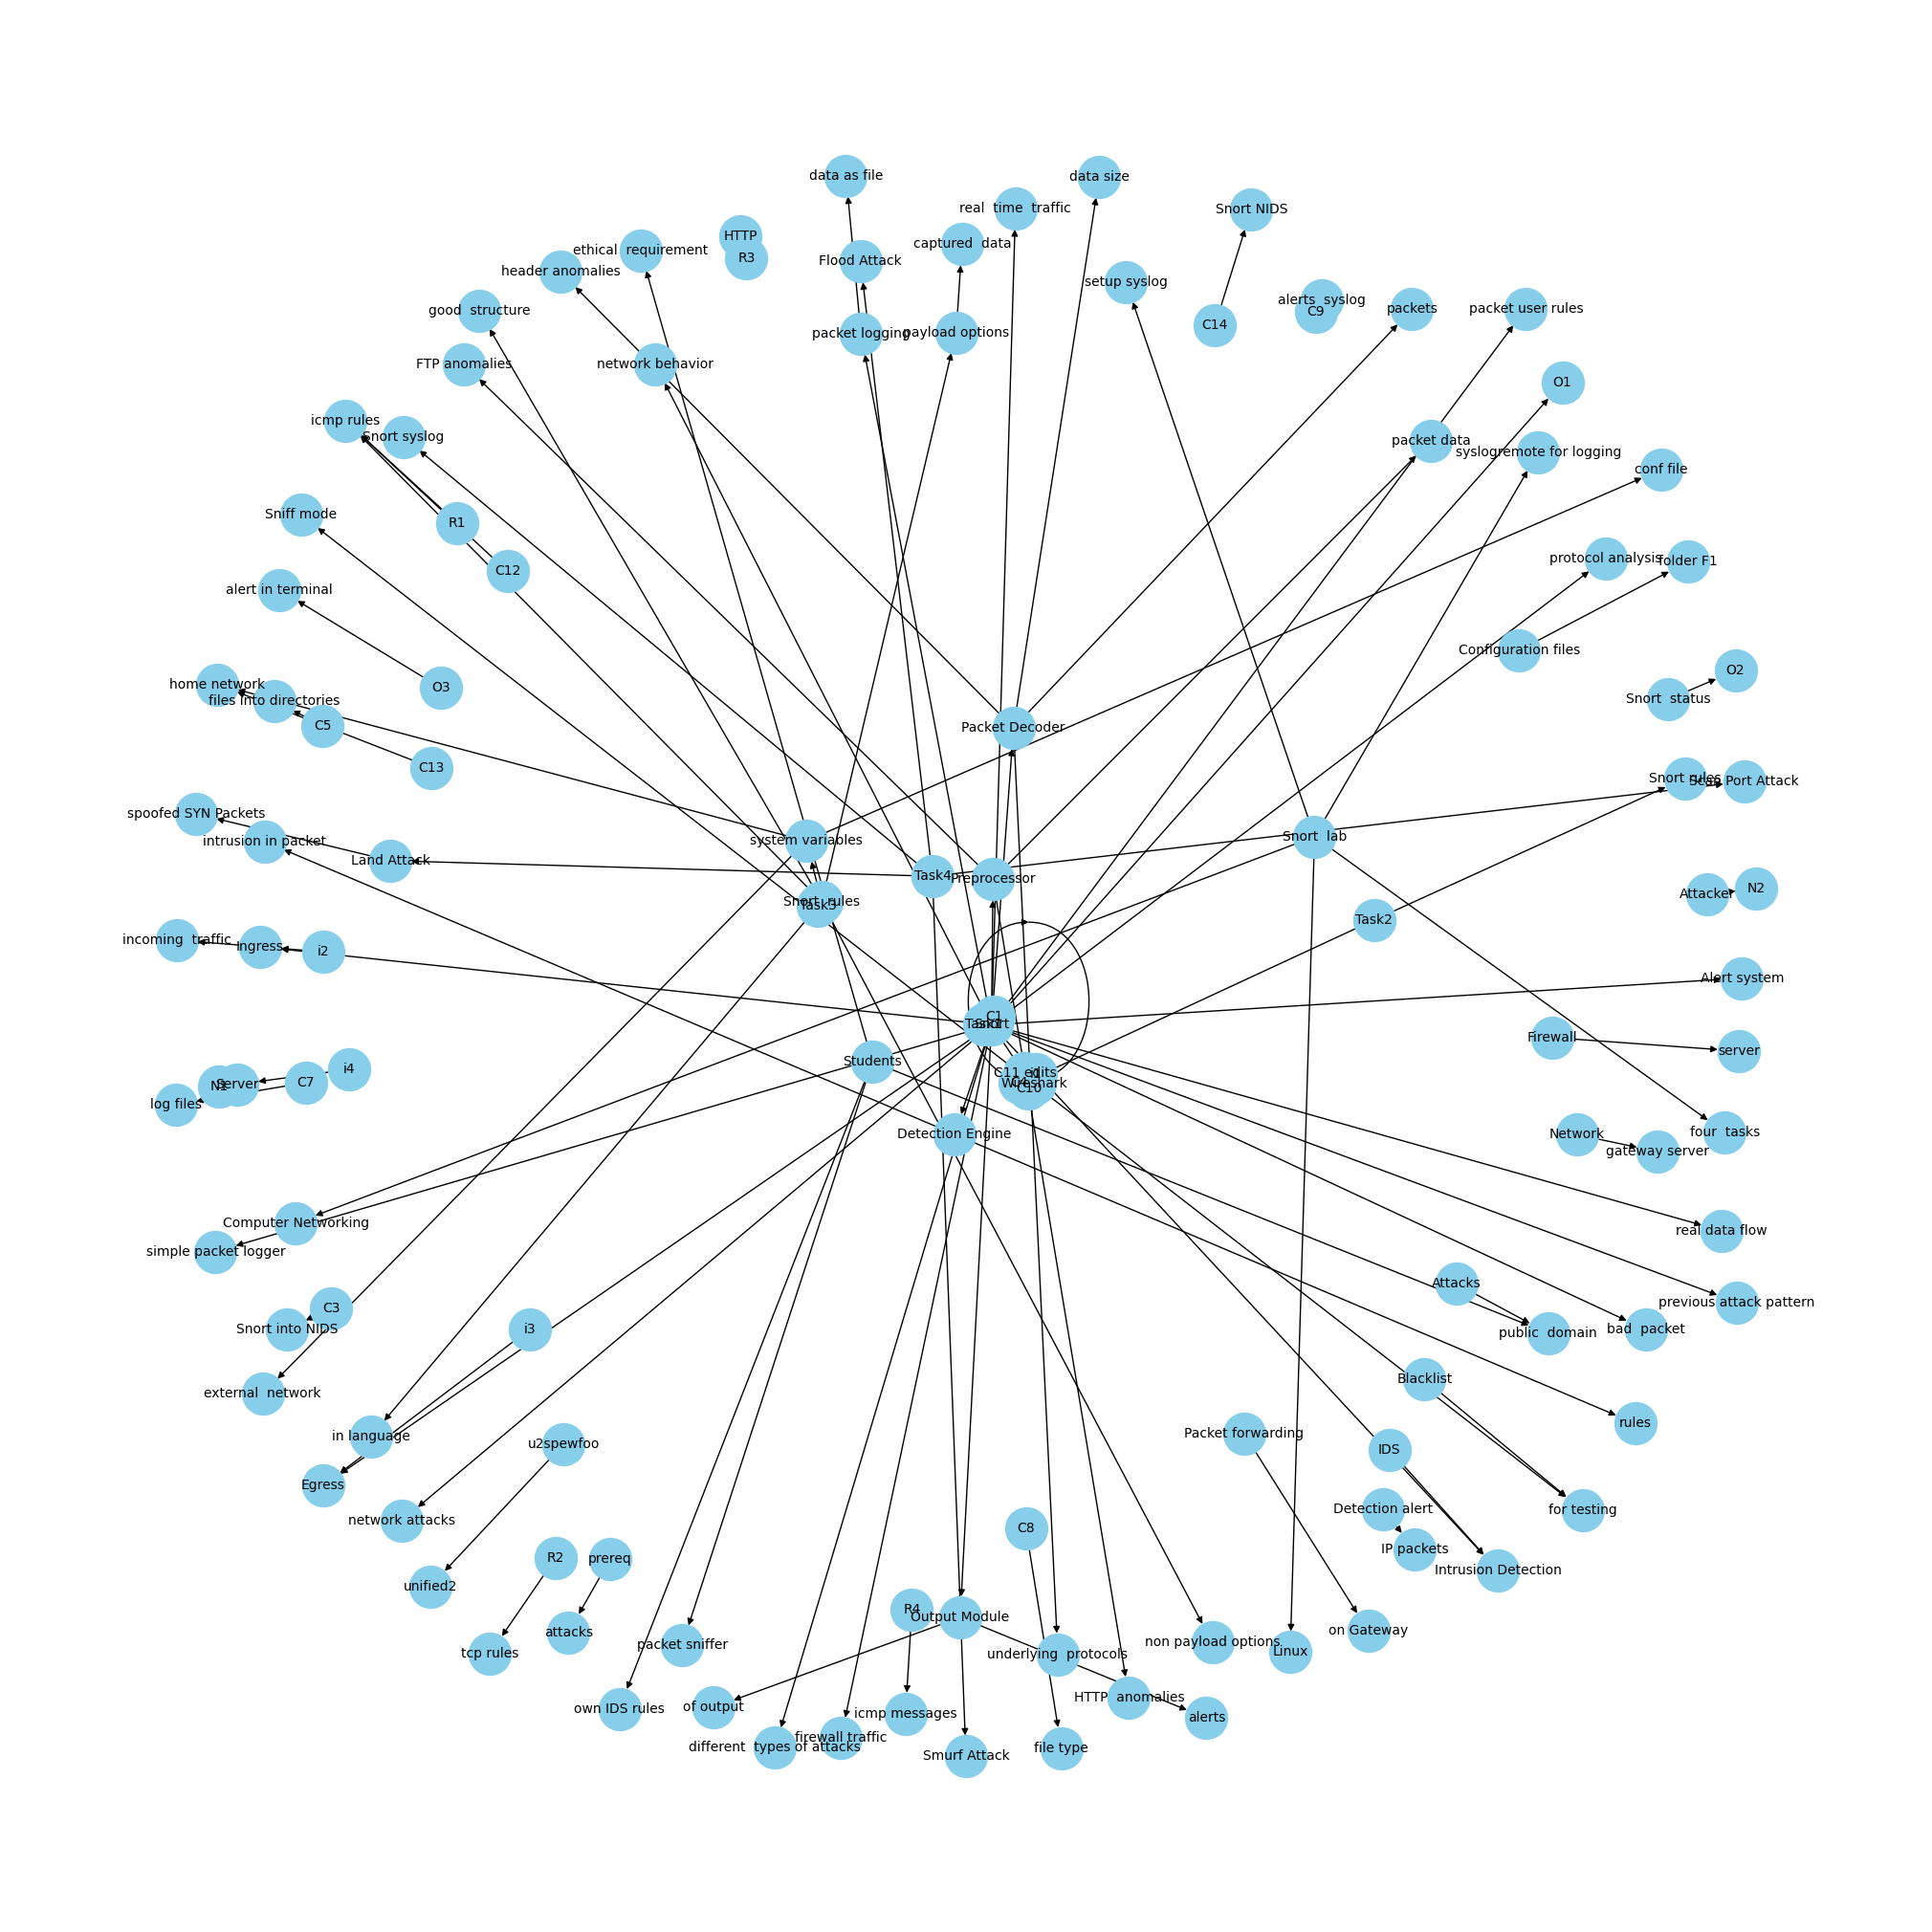

In [60]:
#plot the graph

plt.figure(figsize=(20,20))
pos = nx.spring_layout(G)
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1000, font_size=10, edge_cmap=plt.cm.Blues, pos=pos)
plt.show()


Knowledge Graph generated


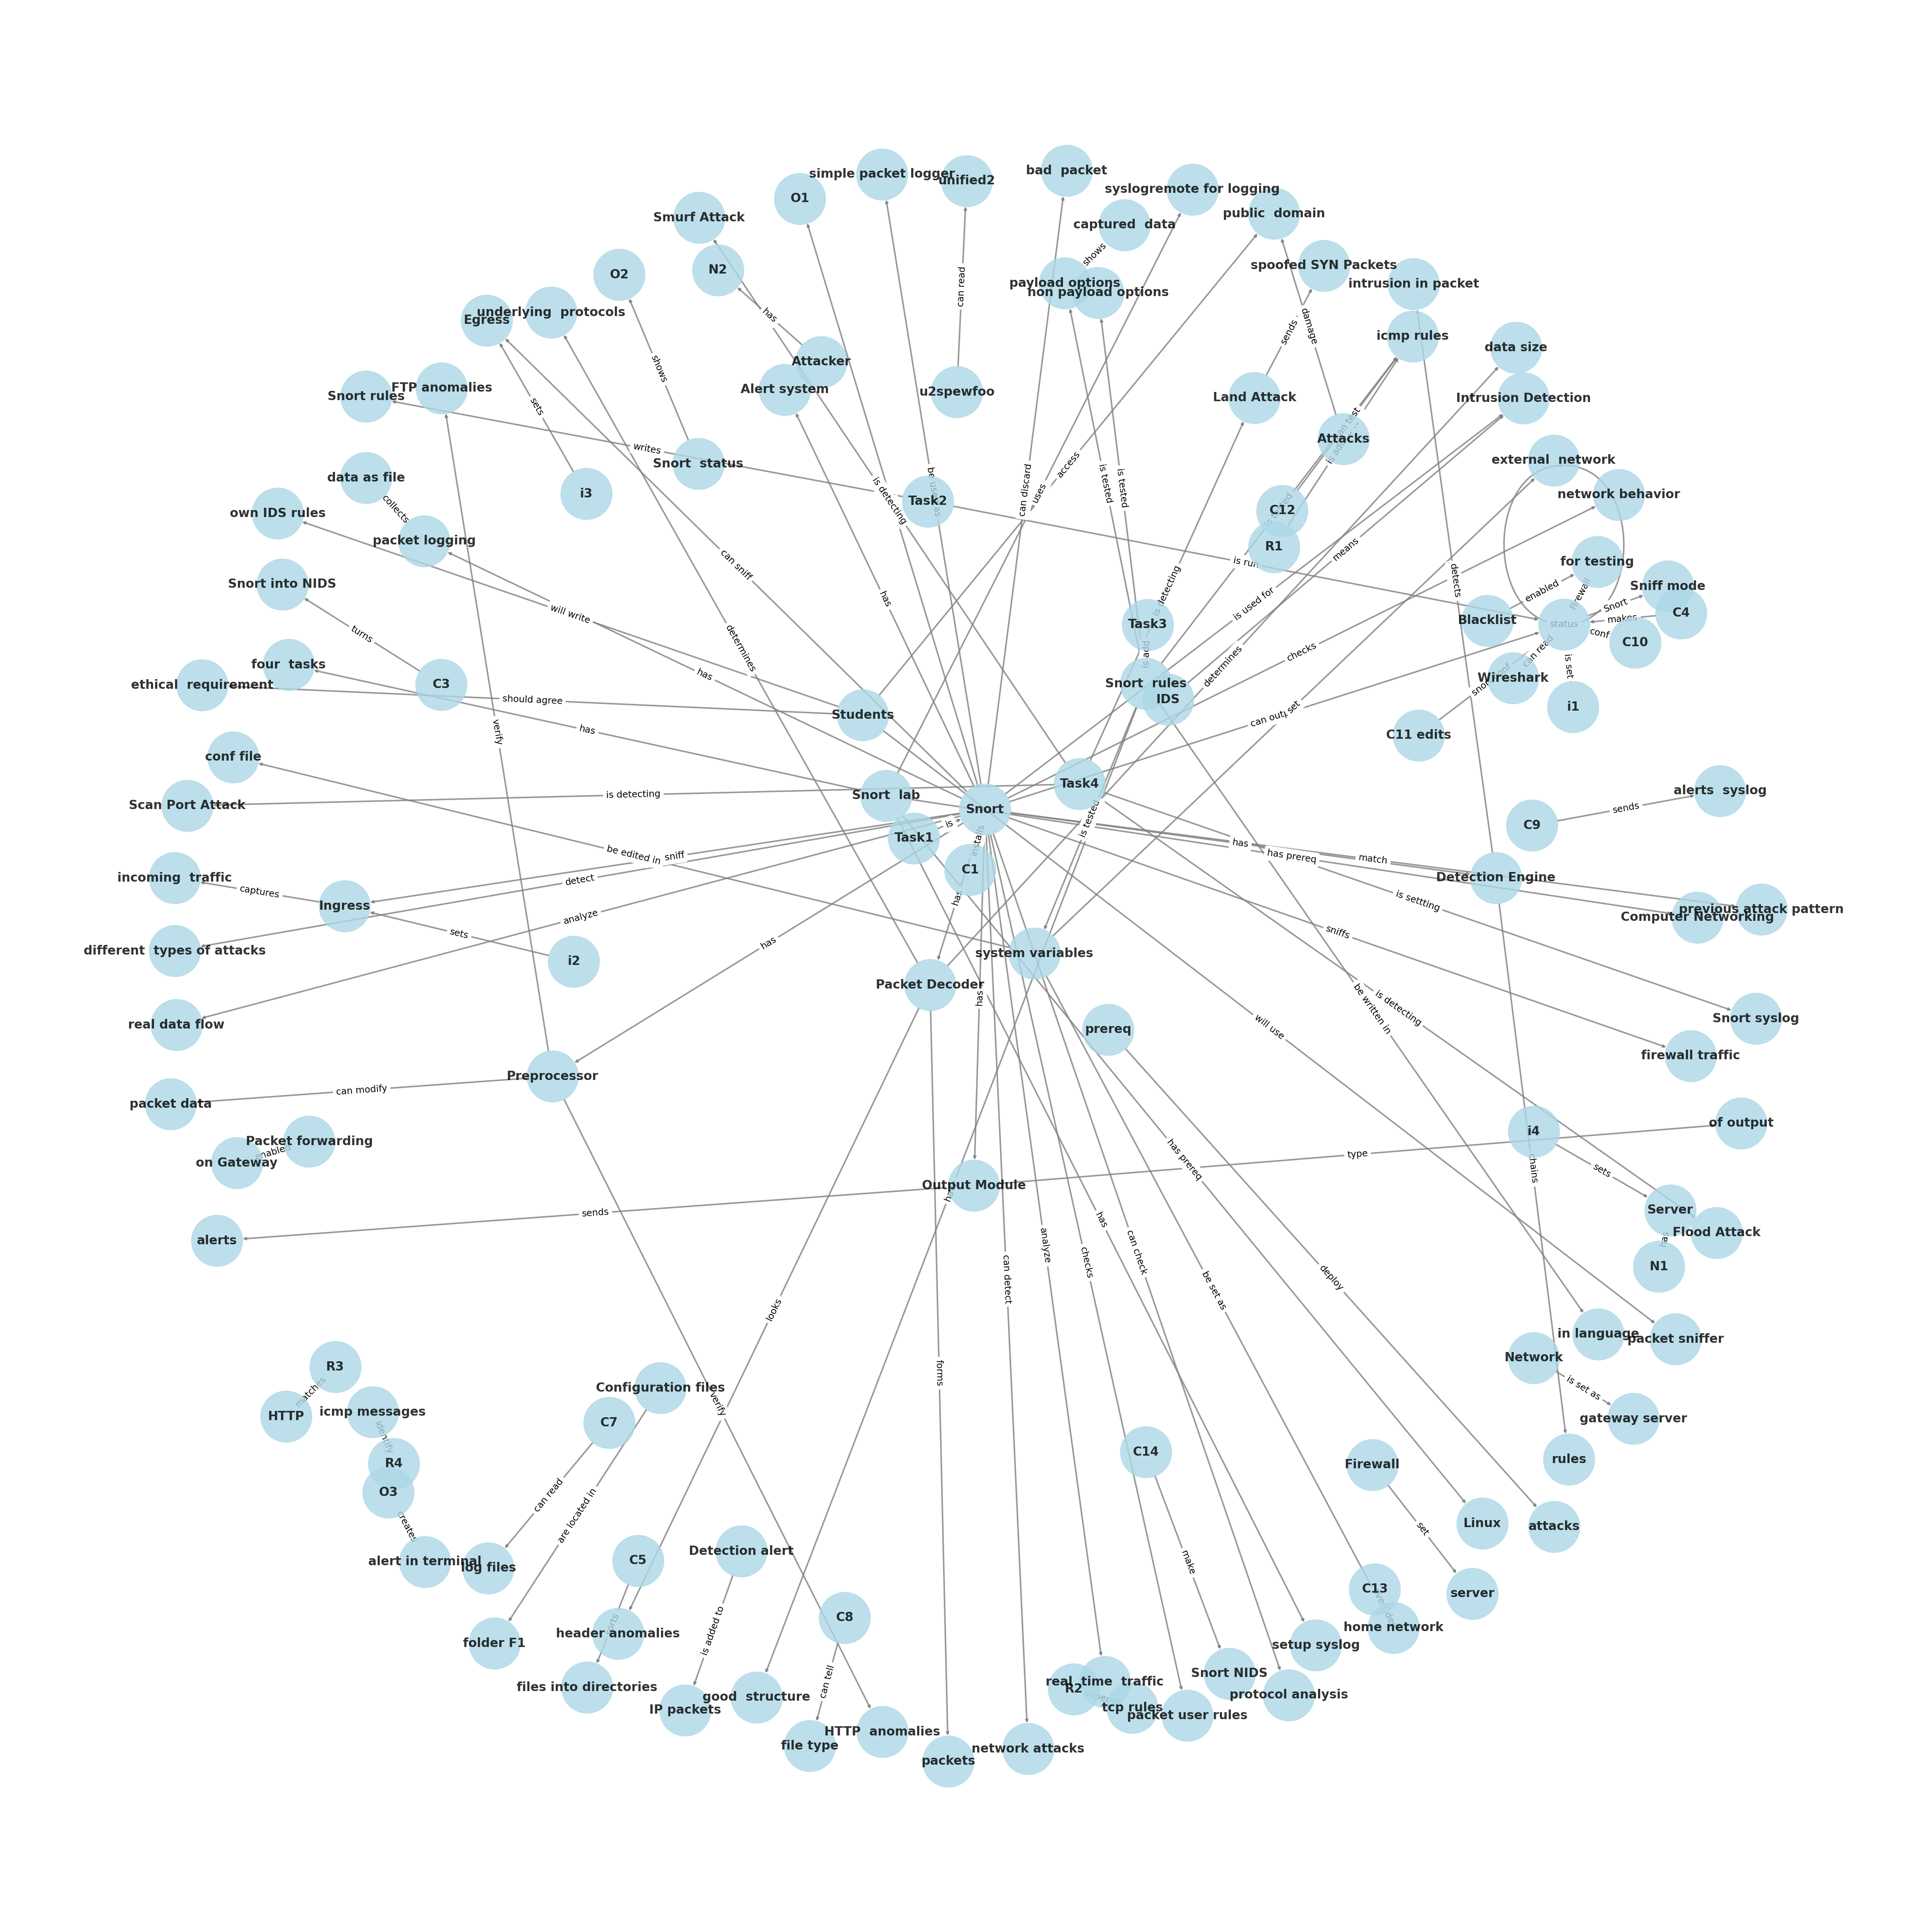

In [66]:
import networkx as nx
import matplotlib.pyplot as plt

# Create a directed graph
G = nx.DiGraph(directed=True)

# Add edges to the graph
for i in range(len(relations)):
    G.add_weighted_edges_from([(source[i], target[i], i)])

print("\nKnowledge Graph generated")

# Set a dynamic figure size based on the number of edges
size = 30  # Increased figure size
if (len(G.edges) / 2) > 20:
    size = len(relations) / 2
plt.figure(figsize=(size, size))

# Create edge labels dictionary based on the weights
edge_labels = dict([((u, v), relations[d['weight']]) for u, v, d in G.edges(data=True)])

# Use spring_layout with a higher 'k' value for better spacing
pos = nx.spring_layout(G, k=1.2, iterations=100)

# Draw the graph with larger node sizes and much larger font sizes for readability
nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=10000,  # Further increased node size
        font_size=24, font_weight='bold',  # Further increased and bold font size for labels
        edge_color='gray', edge_cmap=plt.cm.Blues, width=3, alpha=0.8)  # Increased edge width slightly for more clarity

# Draw edge labels with much larger font size for better readability
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=18, label_pos=0.5)  # Further increased edge label font size

# Show the graph
plt.show()
